In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from logloss import *
from data_visualizer import viz_logloss

In [2]:
seasons = range(2001, 2018, 1)
df = None
for season in seasons:
    try:
        temp_df = pd.read_csv('data/prep/{}_NBAseason.csv'.format(season))
        if df is None:
            df = temp_df
        else:
            df = df.append(temp_df, ignore_index=True)
    except FileNotFoundError:
        print('ERROR: data/prep/{}_NBAseason.csv not found'.format(season))

In [3]:
#seperating data set randomly into train, cross validation, and test sets
msk = np.random.rand(len(df)) < 0.6
train = df[msk]
test_cval = df[~msk]
msk = np.random.rand(len(test_cval)) < 0.5
cval = test_cval[msk]
test = test_cval[~msk]

In [4]:
print('Train: ', len(train), '\n'
      'X Val: ', len(cval), '\n'
      'Test: ', len(test))

Train:  13222 
X Val:  4331 
Test:  4353


In [5]:
#isolating features from dataframe

features = ['Day_Num', 'Home_ELO', 'Visitor_ELO',
            'Home_TotalWins','Home_TotalLosses', 'Home_HomeWins', 'Home_HomeLosses', 'Home_Streak', 
            'Home_AvgSpread', 'Home_AvgPTS', 'Home_GamesPlayed',  
            'Visitor_TotalWins', 'Visitor_TotalLosses', 'Visitor_VisitorWins', 'Visitor_VisitorLosses', 'Visitor_Streak', 
            'Visitor_AvgSpread', 'Visitor_AvgPTS', 'Visitor_GamesPlayed']
            
#features = ['Home_ELO', 'Visitor_ELO', 'Home_AvgPTS', 'Visitor_AvgPTS', 'Home_AvgSpread', 'Visitor_AvgSpread']

train_features = train[features]
cval_features = cval[features]
test_features = test[features]


train_labels = train['Winner']
cval_labels = cval['Winner']
test_labels = test['Winner']

#### Using scikit-learns RandomForestClassifier to Evaluate Features

In [6]:
clf = RandomForestClassifier()

# fitting the random forest to the training data
clf.fit(train_features, train_labels)

feature_importance = clf.feature_importances_

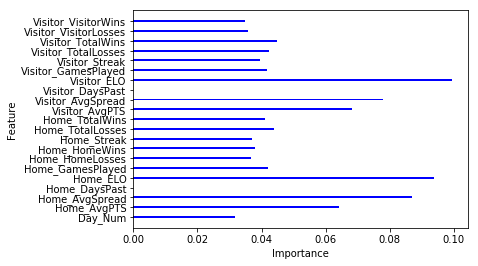

In [7]:
fig, ax = plt.subplots()
rects = ax.barh(features, feature_importance, 0.2, color='b')

#adding labels
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')

plt.show()

#### Creating a Logistic Regression model using the Feature Importance values from the RandomForest

In [8]:
clf = LogisticRegression()
clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Computing the Ideal NN size through minimization of Logloss

In [ ]:
(logloss, num_layers, num_perceptrons, logloss_list, layers_list, perceptrons_list) =\
    minimize_logloss(train_features, train_labels, cval_features, cval_labels.tolist(), max_perceptrons=150, increment=5)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


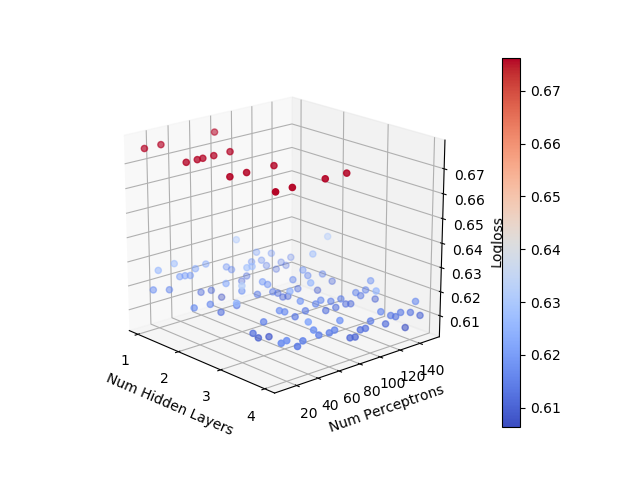

Minimum Logloss Found: 0.606316878889258
Hidden Layers @ Min: 1
Perceptrons @ Min: 80


In [7]:
%matplotlib notebook

X = np.asarray(layers_list)
Y = np.asarray(perceptrons_list)
Z = np.asarray(logloss_list)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#3d scatter plot w/ heatmap
ax.scatter(X, Y, Z, c=Z, cmap=cm.coolwarm)

colmap = cm.ScalarMappable(cmap=cm.coolwarm)
colmap.set_array(Z)
cb = fig.colorbar(colmap)

ax.set_xlabel('Num Hidden Layers')
ax.set_ylabel('Num Perceptrons')
ax.set_zlabel('Logloss')

plt.xticks(np.arange(min(X), max(X)+1, 1))
plt.show()

print('Minimum Logloss Found: {loss}\nHidden Layers @ Min: {lay}\nPerceptrons @ Min: {perc}'\
      .format(loss=logloss,lay=num_layers,perc=num_perceptrons))

In [27]:
#num_perceptrons = 15
#num_layers = 3
clf = MLPClassifier(solver='lbfgs', activation='logistic', alpha=1e-5,\
                    hidden_layer_sizes=(num_perceptrons, num_layers), random_state=1)

In [28]:
clf.fit(train_features, train_labels)

MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

#### Creating predictions on the different data sets

In [9]:
train_predictions = clf.predict_proba(train_features)
cval_predictions = clf.predict_proba(cval_features)
test_predictions = clf.predict_proba(test_features)

In [10]:
print(test_predictions)

[[0.44692097 0.55307903]
 [0.44692097 0.55307903]
 [0.26335372 0.73664628]
 ...
 [0.19461309 0.80538691]
 [0.35436846 0.64563154]
 [0.58685228 0.41314772]]


#### Traing Set LogLoss Evaluation

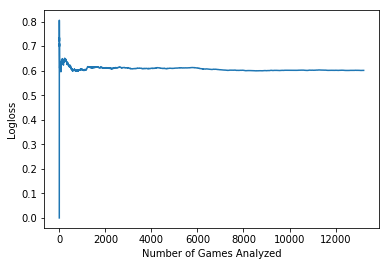

FINAL TRAINING STATS
Logloss:  0.601060698000052
Precision:  0.6939948892674617
Recall:  0.7315375982042649
Accuracy:  0.6738768718801996
F1 Score:  0.7122718828543328


In [11]:
%matplotlib inline

y_train = train_labels.tolist()
p_train = train_predictions[:,1].tolist()

logloss = compute_logloss(p_train, y_train)
(F1, precision, recall, accuracy) = compute_stats(p_train, y_train)

viz_logloss(p_train, y_train)
print('FINAL TRAINING STATS')
print('Logloss: ', logloss)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('F1 Score: ', F1)

#### Cross Validation Set LogLoss Evaluation

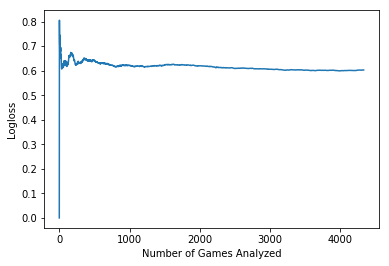

FINAL CROSS VAL. STATS
Logloss:  0.6025483210367661
Precision:  0.6881859264041317
Recall:  0.7316403568977351
Accuracy:  0.6728238282151928
F1 Score:  0.7092481703260145


In [12]:
%matplotlib inline

y_cval = cval_labels.tolist()
p_cval = cval_predictions[:,1].tolist()

logloss = compute_logloss(p_cval, y_cval)
(F1, precision, recall, accuracy) = compute_stats(p_cval, y_cval)

viz_logloss(p_cval, y_cval)
print('FINAL CROSS VAL. STATS')
print('Logloss: ', logloss)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('F1 Score: ', F1)

#### Test Set LogLoss Evaluation

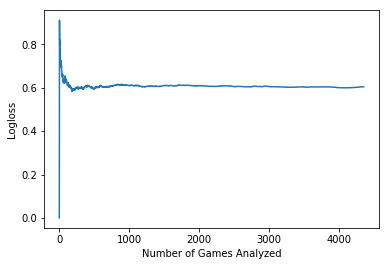

FINAL TEST STATS
Logloss:  0.6040164498484987
Precision:  0.6938841899804814
Recall:  0.7287324906047147
Accuracy:  0.6724098322995635
F1 Score:  0.7108815197467088


In [13]:
%matplotlib inline

y_test = test_labels.tolist()
p_test = test_predictions[:,1].tolist()

logloss = compute_logloss(p_test, y_test)
(F1, precision, recall, accuracy) = compute_stats(p_test, y_test)

viz_logloss(p_test, y_test)
print('FINAL TEST STATS')
print('Logloss: ', logloss)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('F1 Score: ', F1)